In [1]:
## Notebook example to read the time-series value / coordinate info

% matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from pysar.objects import timeseries
from pysar.utils import readfile

work_dir = os.path.expanduser('~/insarlab/PYSAR_EXAMPLE/FernandinaSenDT128/PYSAR/GEOCODE')
ts_file   = os.path.join(work_dir, 'geo_timeseries_ECMWF_ramp_demErr_masked.h5')
vel_file  = os.path.join(work_dir, 'geo_velocity_masked.h5')
tcoh_file = os.path.join(work_dir, 'geo_temporalCoherence.h5')


def get_lat_lon(meta, box=None):
    """extract lat/lon info of all grids into 2D matrix
    Parameters: meta : dict, including X/Y_FIRST/STEP and LENGTH/WIDTH info
                box  : 4-tuple of int for (x0, y0, x1, y1)
    Returns:    lats : 2D np.array for latitude  in size of (length, width)
                lons : 2D np.array for longitude in size of (length, width)
    """
    length, width = int(meta['LENGTH']), int(meta['WIDTH'])
    if box is None:
        box = (0, 0, width, length)

    # generate 2D matrix for lat/lon
    lat_num = box[3] - box[1]
    lon_num = box[2] - box[0]
    lat_step = float(meta['Y_STEP'])
    lon_step = float(meta['X_STEP'])
    lat0 = float(meta['Y_FIRST']) + lat_step * box[1]
    lon0 = float(meta['X_FIRST']) + lon_step * box[0]
    lat1 = lat0 + lat_step * lat_num
    lon1 = lon0 + lon_step * lon_num
    lats, lons = np.mgrid[lat0:lat1:lat_num*1j,
                          lon0:lon1:lon_num*1j]
    return lats, lons

def split_into_sub_boxes(ds_shape, win_size=300, print_msg=True):
    """split input shape into multiple sub boxes
    Parameters: ds_shape : 2-tuple of int for the shape of whole dataset in (length, width)
                win_size : int, size of path in one direction
    Returns:    box_list : list of 4-tuple of int, each indicating (col0, row0, col1, row1)
    """
    length, width = ds_shape
    # number of sub boxes
    nrows = np.ceil(length / win_size).astype(int)
    ncols = np.ceil(width / win_size).astype(int)
    if print_msg:
        print('input data shape in row/col: {}/{}'.format(length, width))
        print('max box size: {}'.format(win_size))
        print('number of output boxes: {}'.format(nrows * ncols))
    # start/end row/column number of each box
    box_list = []
    for i in range(nrows):
        r0 = i * win_size
        r1 = min([length, r0 + win_size])
        for j in range(ncols):
            c0 = j * win_size
            c1 = min([width, c0 + win_size])
        box = (c0, r0, c1, r1)
        box_list.append(box)
    return box_list

print('Done.')

Done.


In [2]:
ts_obj = timeseries(ts_file)
ts_obj.open()

# split into multiple boxes and read the data for the first one as demo
box_list = split_into_sub_boxes((ts_obj.length, ts_obj.width))
box = box_list[0]

if box is None:
    box = (0, 0, ts_obj.width, ts_obj.length)
length = box[3] - box[1]
width = box[2] - box[0]

# 1 Date
dates = np.array(ts_obj.times)

# 2 Spatial coordinates
lats, lons = get_lat_lon(ts_obj.metadata, box=box)
rows, cols = np.mgrid[box[1]:box[3] - 1:length * 1j,
                      box[0]:box[2] - 1:width * 1j]

# 3 Velocity / time-series
print('read velocity data')
vel = readfile.read(vel_file, datasetName='velocity', box=box)[0] * 100.
vel_std = readfile.read(vel_file, datasetName='velocityStd', box=box)[0] * 100.
print('read time-series data')
ts_data = readfile.read(ts_file, box=box)[0] * 100.
ts_data -= np.tile(ts_data[0, :, :], (ts_data.shape[0], 1, 1))  # enforce displacement starts from zero
print('read temporal coherence data')
temp_coh = readfile.read(tcoh_file, box=box)[0]
mask = ~np.isnan(vel)

open timeseries file: geo_timeseries_ECMWF_ramp_demErr_masked.h5
input data shape in row/col: 450/600
max box size: 300
number of output boxes: 4
read velocity data
read time-series data
read temporal coherence data


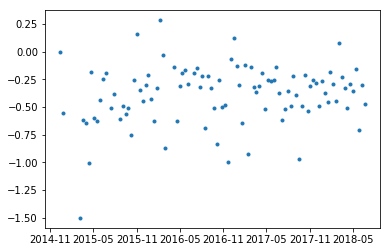

In [4]:
# This is how the time-series looks like
idx = 100
plt.figure()
plt.plot(dates, ts_data[:, idx, idx], '.')
plt.show()

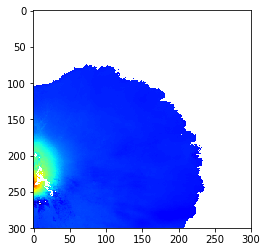

In [5]:
# This is how the data looks like in velocity map
plt.figure()
plt.imshow(vel, cmap='jet')
plt.show()